## Setup

In [1]:
!pip install wandb tsai more-itertools holidays >> /dev/null

In [2]:
from tsai.all import *
my_setup()

os              : Linux-5.10.133+-x86_64-with-glibc2.27
python          : 3.8.16
tsai            : 0.3.4
fastai          : 2.7.10
fastcore        : 1.5.27
torch           : 1.13.0+cu116
device          : cpu
cpu cores       : 1
threads per cpu : 2
RAM             : 12.68 GB
GPU memory      : N/A


In [3]:
import wandb

wandb_username = "bdsaglam"
wandb_token = "" # TODO

!wandb login --relogin $wandb_token

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
wandb_run = wandb.init(
    project='ytd-cassandra-forecast', 
    entity='ytdteam'
)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bdsaglam (ytdteam). Use `wandb login --relogin` to force relogin


In [33]:
import datetime
import json
import pickle
import warnings
from pathlib import Path

import holidays
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import wandb
from fastai.callback.tracker import SaveModelCallback
from fastai.callback.wandb import *
from more_itertools import windowed
from pandas.api.types import CategoricalDtype
from sklearn.compose import ColumnTransformer
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from tsai.all import *
from tsai.data.tabular import EarlyStoppingCallback

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

EXPORTS_DIR = Path("./exports")
EXPORTS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR = Path("./figures")
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# Data

SYMBOL = 'META'

def load_stock_price_dataset(path):
    df = pd.read_csv(
            path,
            index_col='datetime', 
            parse_dates={'datetime': ['<DATE>', '<TIME>']},
            usecols=['<DATE>', '<TIME>', '<CLOSE>'], 
            na_values=['nan']
    ).rename(columns={'<CLOSE>': 'Close'})   
    return pd.DataFrame(index=df.index, data=dict(price=df.Close.values))

# Splits


def get_splits(df, cutoff_datetime):
    if isinstance(cutoff_datetime, str):
        cutoff_datetime = datetime.datetime.fromisoformat(cutoff_datetime)
    start_date = df.index.min()
    end_date = df.index.max()
    assert cutoff_datetime > start_date
    assert cutoff_datetime < end_date
    indices = np.arange(len(df))
    return (
        indices[df.index < cutoff_datetime].tolist(),
        indices[df.index >= cutoff_datetime].tolist(),
    )


# Features

import datetime

import holidays
import pandas as pd


def is_us_holiday(dt):
    return dt.strftime("%Y-%m-%d") in holidays.UnitedStates()


def extract_datetime_features(ds):
    df = pd.DataFrame()
    df.index = ds
    df["day"] = ds.day
    df["hour"] = ds.hour
    df["month_name"] = ds.month_name()
    df["day_name"] = ds.day_name()
    df["is_weekend"] = (ds.day_name() == 'Saturday') | (ds.day_of_week == 'Sunday')
    df["is_month_start"] = ds.is_month_start
    df["is_quarter_start"] = ds.is_quarter_start
    df["is_month_end"] = ds.is_month_end
    df["is_year_start"] = ds.is_year_start
    # US holidays
    df["is_holiday"] = pd.Series(ds.values).apply(is_us_holiday).values
    df["is_day_before_holiday"] = (
        pd.Series(ds + datetime.timedelta(days=1)).map(is_us_holiday).values
    )
    df["is_day_after_holiday"] = (
        pd.Series(ds - datetime.timedelta(days=1)).map(is_us_holiday).values
    )
    nominals = [
        "hour",
        "day",
        "day_name",
        "month_name",
        "is_weekend",
        "is_month_start",
        "is_quarter_start",
        "is_month_end",
        "is_year_start",
        "is_holiday",
        "is_day_before_holiday",
        "is_day_after_holiday",
    ]
    for col in nominals:
        if col in df.columns:
            df[col] = df[col].astype("category")

    return df


def add_datetime_features(df):
    return pd.concat([extract_datetime_features(df.index), df], axis=1)


def add_price_change(df):
    df["price_change"] = df.price.diff().fillna(0)
    return df


def order_cols(df):
    categorical_cols = df.select_dtypes("category").columns.tolist()
    numerical_cols = df.select_dtypes("float").columns.tolist()
    existing_cols = set(df.columns)
    col_order = [
        col for col in numerical_cols + categorical_cols if col in existing_cols
    ]
    return df[col_order]


def prepare_dataset(df):
    return df.pipe(add_datetime_features).pipe(add_price_change).pipe(order_cols)

# Time-series dataset

def sliding_window(data, window_size: int):
    """Makes snippets of data for sequence prediction by sliding a window with size `look_back`
    Args:
        data (np.array): data with x and y values, shape = (T, F+1)
        window_size (int): window size
    """
    # shape = (N, W, F+1)
    return np.array(list(windowed(data, window_size)))

def make_ts_samples(data, look_back):
    snippets = sliding_window(data, look_back) # (N, W, F+1)
    x = np.swapaxes(snippets[:, :-1, :-1], 1, 2) # (N, F, W-1)
    y = snippets[:, -1, -1] # (N, )
    return x, y


def make_ts_dataset_split(train_x, train_y, val_x, val_y):
    x = np.concatenate([train_x, val_x], axis=0)
    y = np.concatenate([train_y, val_y], axis=0)
    splits = list(range(len(train_x))), list(range(len(train_x), len(x)))
    return x, y, splits


# Evaluate
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

def visualize_predictions(dates, prices, preds):
    prices = prices.reshape(-1, 1)
    preds = preds.reshape(-1, 1)

    figure, axes = plt.subplots(figsize=(15, 6))
    axes.xaxis_date()
    axes.plot(dates, prices, color = 'red', label = 'Real Stock Price')
    axes.plot(dates, preds, color = 'blue', label = 'Predicted Stock Price')
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{SYMBOL} Stock Price')
    plt.legend()
    plt.show()

def log_scores(prices, preds):
    rmse = np.sqrt(mean_squared_error(prices, preds))
    mape = mean_absolute_percentage_error(prices, preds)
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.2%}")

## Data

In [43]:
config = {
  "seed": 42,
  "wandb": {
    "wandb_enabled": False,
    "wandb_username": "ytdteam",
    "wandb_project": "ytd-cassandra-forecast"
  },
  "data": {
    "path": "ytdteam/ytd-cassandra-forecast/meta-stock-price:v7", # CHANGE ME
    "stock_id": "META",
    "split_date": "2022-10-15", # CHANGE ME
    "look_back": 60
  }
}


In [44]:
dataset_path = config["data"]["path"]
artifact_dir = wandb_run.use_artifact(dataset_path, type="raw_data").download()
dataset_path = f"./{artifact_dir}/{config['data']['stock_id'].lower()}.us.txt"
df = prepare_dataset(load_stock_price_dataset(dataset_path))

row_splits = get_splits(df, config["data"]["split_date"])
df["is_validation"] = False
df.iloc[row_splits[1], df.columns.get_loc("is_validation")] = True
print("validation/train ratio", len(row_splits[1]) / len(row_splits[0]))

wandb:   1 of 1 files downloaded.  


validation/train ratio 0.20371694067190851


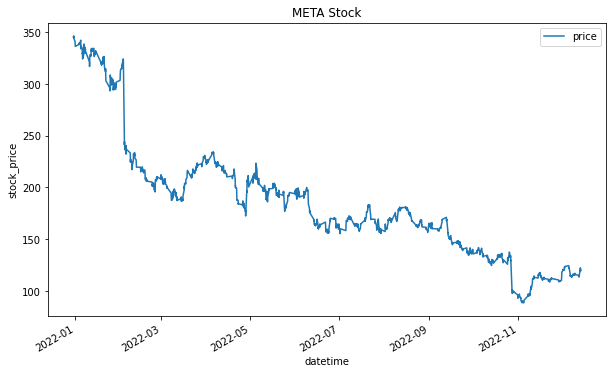

In [45]:
df[['price']].plot(figsize=(10, 6), subplots=True);
plt.ylabel("stock_price")
plt.title(f"{SYMBOL} Stock");

## Inference

Baseline - Moving Average - Validation set
RMSE: 12.2962
MAPE: 8.50%


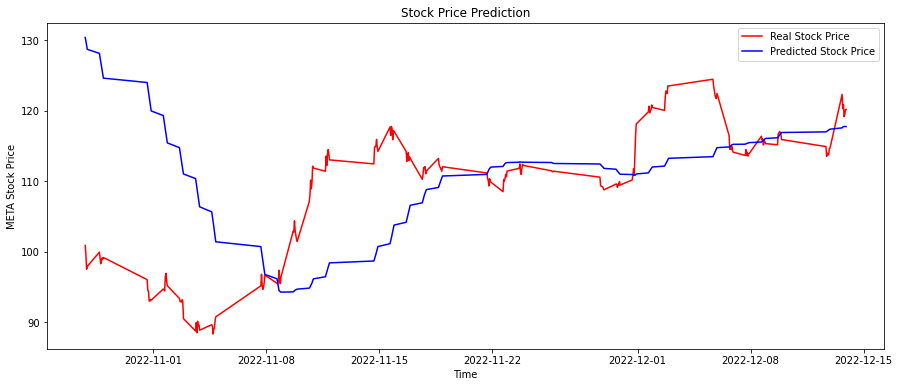

In [46]:
def moving_average(df, window_size) :
    prices = df['price'].values
    ret = np.cumsum(prices, dtype=float)
    ret[window_size:] = ret[window_size:] - ret[:-window_size]
    return ret[window_size - 1:] / window_size

split = row_splits[1]
sdf = df.iloc[split]
dates = sdf.index
prices = sdf['price'].values
look_back = config['data']['look_back']
preds = moving_average(sdf, look_back)

print("Baseline - Moving Average - Validation set")
print("="*80)
log_scores(prices[look_back - 1:], preds)
visualize_predictions(dates[look_back - 1:], prices[look_back - 1:], preds)

Baseline - Naive Forecast - Validation set
RMSE: 2.2327
MAPE: 0.95%


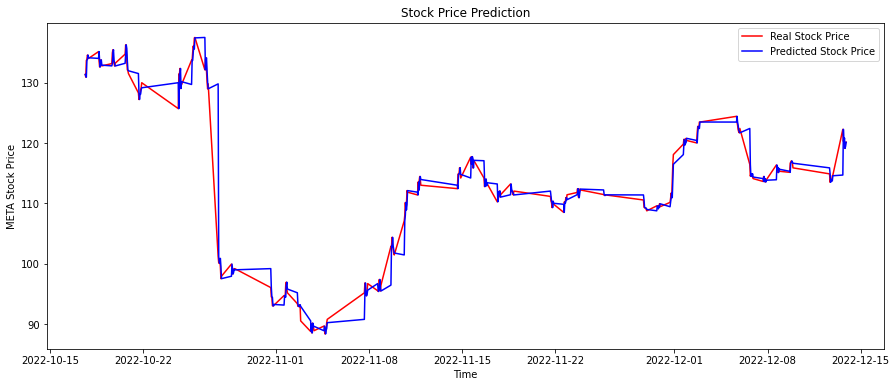

In [47]:
def baseline_naive_forecast(df):
    prices = df['price'].values
    return np.array([prices[0], *prices[:-1]])

split = row_splits[1]
sdf = df.iloc[split]
dates = sdf.index
prices = sdf['price'].values
preds = baseline_naive_forecast(sdf)

print("Baseline - Naive Forecast - Validation set")
print("="*80)
log_scores(prices, preds)
visualize_predictions(dates, prices, preds)

In [48]:
wandb_run.finish(exit_code=0, quiet=True)